In [1]:
from email.mime.image import MIMEImage
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.application import MIMEApplication
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sqlalchemy as sa
import yaml
from db_connection import DBConnection
from config import Config

In [2]:
config = Config()
FROM_YEAR = config.get_int("years", "from_year")
TO_YEAR = config.get_int("years", "to_year")

def create_engine():
    with open('db_connection.yml', 'r') as file:
        config = yaml.safe_load(file)

    database_url = config['database_url']
    database_port = config['database_port']
    database_password = config['database_password']
    database_user = config['database_user']
    database_name = config['database_name']

    connection_string = f"mysql+pymysql://{database_user}:{database_password}@{database_url}:{database_port}/{database_name}"

    # Return SQL engine
    return sa.create_engine(connection_string)

def casworks_to_df_csv(engine, output_file):
    """
    Generate a csv of CAS works to attach to an email.

    Args:
    engine (sqlalchemy engine instance)
    output_file (str): csv path of query results

    Returns:
    df: (pandas df) df of query results
    """
    query = f"""
        WITH cas_pubs AS (
            SELECT * FROM `publications`.`comprehensive_global_works_v3` 
             WHERE institution_name = 'California Academy of Sciences'
             OR author_orcid in (SELECT author_orcid FROM authors where author_orcid != 'NULL' and author_active=1)
            )
            SELECT 
                work_id,
                work_doi,
                work_display_name,
                work_publication_date,
                work_publication_year,
                work_publisher,
                work_journal,
                GROUP_CONCAT(DISTINCT author_name SEPARATOR ', ') AS authors_concatenated,
                work_sustainable_dev_goal,
                work_is_open_access,
                work_cited_by_count

            FROM 
                cas_pubs

            GROUP BY 
                work_id,
                work_doi,
                work_display_name,
                work_publication_date,
                work_publication_year,
                work_publisher,
                work_journal,
                work_sustainable_dev_goal,
                work_is_open_access,
                work_cited_by_count

             HAVING
                 work_publication_year = {FROM_YEAR}
            ORDER BY authors_concatenated;
"""
    df = pd.read_sql_query(query, engine)
    df.to_csv(output_file, index=False)
    return df

# this is not a very helpful vis
def create_lineplot(df, time_period=FROM_YEAR):
    plt.figure(figsize=(10, 5))
    grouped_df = df.groupby('work_publication_date').count().reset_index()
    plt.plot(grouped_df['work_publication_date'], grouped_df['work_id'])
    plt.title(f'Works published over {time_period}')
    plt.xlabel('Date')
    plt.ylabel('Publications')
    plt.grid(True)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Adjust the interval based on your data span
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate() 
    plt.savefig(f'email_attachments/publications_{FROM_YEAR}.png')
    plt.close()

def create_email(subject, body, attachment_filename_list):
    sender_email = ""
    receiver_email = ""
    password = ""

    message = MIMEMultipart()
    message["From"] = sender_email
    message["To"] = receiver_email
    message["Subject"] = subject

    # Attach the body with the email
    message.attach(MIMEText(body, "plain"))

    # Attach the CSV file + visualizations
    for attachment_filename in attachments:
        with open(attachment_filename, "rb") as file:
            if attachment_filename.endswith('.png'):
                part = MIMEImage(file.read(), Name=attachment_filename)
            else:
                part = MIMEApplication(
                    file.read(),
                    Name=attachment_filename
            )
    part['Content-Disposition'] = f'attachment; filename="{attachment_filename}"'
    message.attach(part)

    return message

    # Send the email - need help with this
    # server = smtplib.SMTP('smtp.gmail.com', 587) 
    # server.starttls() # encrypts email
    # server.login(sender_email, password)
    # server.sendmail(sender_email, receiver_email, message.as_string())
    # server.quit()

In [3]:
engine = create_engine()
df = query_to_csv(engine, f'email_attachments/works_{FROM_YEAR}.csv' )
create_lineplot(df)
attachments = [f'email_attachments/publications_{FROM_YEAR}.png', f'email_attachments/works_{FROM_YEAR}.csv']
email = create_email("Test Publications", "This is a test", attachments)
print(email) 

Content-Type: multipart/mixed; boundary="===============7445193807503802280=="
MIME-Version: 1.0
From: 
To: 
Subject: Test Publications

--===============7445193807503802280==
Content-Type: text/plain; charset="us-ascii"
MIME-Version: 1.0
Content-Transfer-Encoding: 7bit

This is a test
--===============7445193807503802280==
Content-Type: application/octet-stream; Name="email_attachments/works_2022.csv"
MIME-Version: 1.0
Content-Transfer-Encoding: base64
Content-Disposition: attachment; filename="email_attachments/works_2022.csv"

d29ya19pZCx3b3JrX2RvaSx3b3JrX2Rpc3BsYXlfbmFtZSx3b3JrX3B1YmxpY2F0aW9uX2RhdGUs
d29ya19wdWJsaWNhdGlvbl95ZWFyLHdvcmtfcHVibGlzaGVyLHdvcmtfam91cm5hbCxhdXRob3Jz
X2NvbmNhdGVuYXRlZCx3b3JrX3N1c3RhaW5hYmxlX2Rldl9nb2FsLHdvcmtfaXNfb3Blbl9hY2Nl
c3Msd29ya19jaXRlZF9ieV9jb3VudApodHRwczovL29wZW5hbGV4Lm9yZy9XNDMxMjg1MDkzMCxo
dHRwczovL2RvaS5vcmcvMTAuMTAwNy85NzgtMy0wMzEtMDYxNTMtMF8xOSxUaGUgVGVycmVzdHJp
YWwgUmVwdGlsZXMgb2YgdGhlIEd1bGYgb2YgR3VpbmVhIE9jZWFuaWMgSXNsYW5kcywyMDIyLTAx
LT

# some visualizations potentially to add

In [18]:
df = pd.read_csv('email_attachments/works_2022.csv')
df

,work_id,work_doi,work_display_name,work_publication_date,work_publication_year,work_publisher,work_journal,authors_concatenated,work_sustainable_dev_goal,work_is_open_access,work_cited_by_count
0,https://openalex.org/W4312850930,https://doi.org/10.1007/978-3-031-06153-0_19,The Terrestrial Reptiles of the Gulf of Guinea...,2022-01-01,2022,Springer Nature,Springer eBooks,"Aaron M. Bauer, Rayna C. Bell",Life below water,1,3
1,https://openalex.org/W4296816995,https://doi.org/10.1111/muan.12228,Issue Information,2022-09-01,2022,Wiley-Blackwell,Museum anthropology,Adrian Van Allen,-1,1,0
2,https://openalex.org/W4283749290,https://doi.org/10.1016/j.scitotenv.2022.157049,Mesophotic depths hide high coral cover commun...,2022-10-01,2022,Elsevier BV,Science of the total environment,"Alejandra Hernández‐Agreda, Pim Bongaerts",Life below water,0,3
3,https://openalex.org/W4226315466,https://doi.org/10.1111/conl.12875,Hidden in the deep: Distinct benthic trajector...,2022-02-03,2022,Wiley,Conservation letters,"Alejandra Hernández‐Agreda, Pim Bongaerts",Life below water,1,3
4,https://openalex.org/W4221123915,https://doi.org/10.1093/gbe/evac044,Chromosome-Level Genome Assembly of the Biolum...,2022-03-29,2022,Oxford University Press,Genome biology and evolution,"Alison L. Gould, Athena Lam, Jim Henderson",Life below water,1,3
...,...,...,...,...,...,...,...,...,...,...,...
214,https://openalex.org/W4301368739,https://doi.org/10.11646/zootaxa.5194.2.3,A new species of the grenadier genus Coelorinc...,2022-10-05,2022,Q15088586,Zootaxa,Tomio Iwamoto,Life below water,0,1
215,https://openalex.org/W4308181751,https://doi.org/10.1111/ele.14135,The gut microbiome reflects ancestry despite d...,2022-11-04,2022,Wiley-Blackwell,Ecology letters,W. Brian Simison,Life on land,0,6
216,https://openalex.org/W4221060004,https://doi.org/10.1186/s12915-022-01271-w,Phylogenomic analysis of Syngnathidae reveals ...,2022-03-27,2022,BioMed Central,BMC biology,W. Brian Simison,Life below water,1,21
217,https://openalex.org/W4394314429,https://doi.org/10.6084/m9.figshare.19445186,Additional file 2 of Phylogenomic analysis of ...,2022-01-01,2022,Figshare (United Kingdom),Figshare,W. Brian Simison,-1,1,0


In [19]:
goal_counts= df.groupby('work_sustainable_dev_goal').size().reset_index(name='counts')
goal_counts

,work_sustainable_dev_goal,counts
0,-1,60
1,Clean water and sanitation,1
2,Climate action,1
3,Gender equality,1
4,Good health and well-being,2
5,Life below water,82
6,Life on land,59
7,No poverty,1
8,Partnerships for the goals,2
9,"Peace, justice, and strong institutions",1


In [20]:
goal_counts = goal_counts[(goal_counts['work_sustainable_dev_goal'] != "-1")]
goal_counts = goal_counts.sort_values('counts')
goal_counts

,work_sustainable_dev_goal,counts
1,Clean water and sanitation,1
2,Climate action,1
3,Gender equality,1
7,No poverty,1
9,"Peace, justice, and strong institutions",1
10,Quality education,1
11,Responsible consumption and production,1
4,Good health and well-being,2
8,Partnerships for the goals,2
12,Sustainable cities and communities,2


In [21]:
y = goal_counts['counts']
labels = goal_counts['work_sustainable_dev_goal']

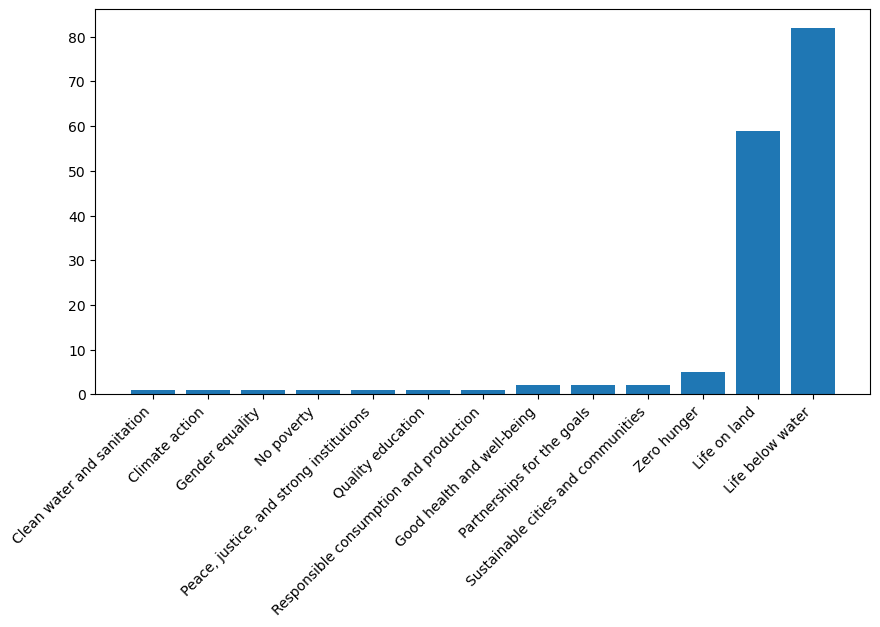

In [22]:
plt.figure(figsize=(10,5))
plt.bar(x=labels, height=y)
plt.xticks(rotation=45,ha='right')
plt.show()

In [23]:
# Normalizing
total = goal_counts['counts'].sum()
goal_counts['normalized'] = goal_counts['counts'].apply(lambda x: x / total )
goal_counts

,work_sustainable_dev_goal,counts,normalized
1,Clean water and sanitation,1,0.006289
2,Climate action,1,0.006289
3,Gender equality,1,0.006289
7,No poverty,1,0.006289
9,"Peace, justice, and strong institutions",1,0.006289
10,Quality education,1,0.006289
11,Responsible consumption and production,1,0.006289
4,Good health and well-being,2,0.012579
8,Partnerships for the goals,2,0.012579
12,Sustainable cities and communities,2,0.012579


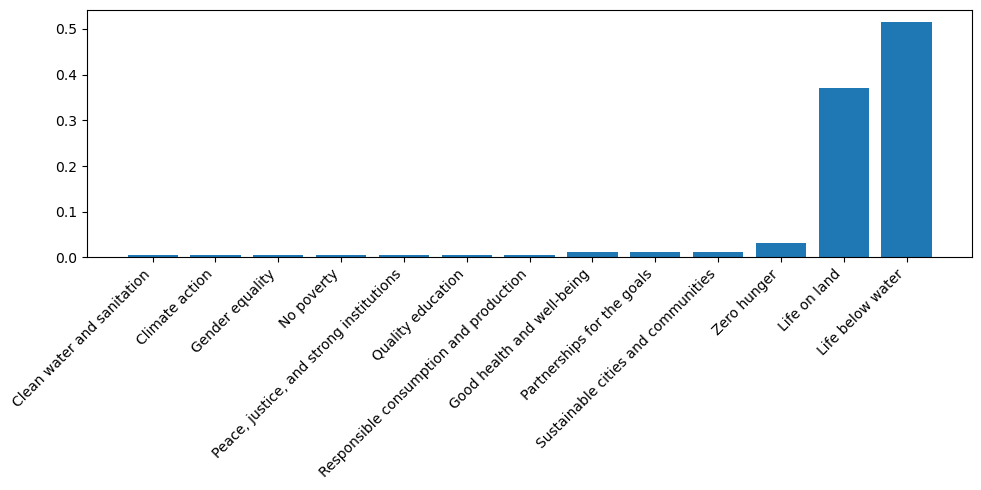

In [24]:

labels = goal_counts['work_sustainable_dev_goal']
y = goal_counts['normalized']

plt.figure(figsize=(10,5))
plt.bar(x=labels, height=y)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()  
plt.show()

# trying interactive bokeh

In [25]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook

# change this to save to html file if needed
output_notebook() 

# Convert DataFrame to a ColumnDataSource for Bokeh
source = ColumnDataSource(data=dict(
    categories=labels,
    values=y
))

# Create a new plot with a title and axis labels
p = figure(title="Sustainable Development Goals", x_axis_label='Goal', y_axis_label='Count',
           x_range=labels, tools="")

# Add a bar renderer with a hover tool
p.vbar(x='categories', top='values', source=source, width=0.9)

# Add HoverTool to the figure
hover = HoverTool()
hover.tooltips = """
    <div>
        <h3>@categories</h3>
        <div><strong>Value: </strong>@values</div>
    </div>
"""
p.add_tools(hover)

show(p)

Loading BokehJS ...